In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/"
df_original = pd.read_csv(file_path + "original_cleaned_dataset.csv")
df_smote = pd.read_csv(file_path + "smote_dataset.csv")
df_weighted = pd.read_csv(file_path + "oversampled_dataset.csv")
df_adasyn = pd.read_csv(file_path + "adasyn_dataset.csv")
df_test = pd.read_csv(file_path + "test_dataset.csv")


In [3]:
# calculcate class weights for the original cleaned dataset
class_weights_original = compute_class_weight('balanced', classes=np.unique(df_original['fraud_reported']), y=df_original['fraud_reported'])
class_weight_dict_original = dict(zip(np.unique(df_original['fraud_reported']), class_weights_original))
df_original_with_weight = df_original.copy()

# calculate class weights for the oversampled dataset
class_weights_oversampled = compute_class_weight('balanced', classes=np.unique(df_weighted['fraud_reported']), y=df_weighted['fraud_reported'])
class_weight_dict_oversampled = dict(zip(np.unique(df_weighted['fraud_reported']), class_weights_oversampled))

In [4]:
# create a random forest model and train on the 5 dataset to determine fraud cases
datasets = [df_original, df_original_with_weight, df_smote, df_adasyn, df_weighted]
x_test = df_test.drop('fraud_reported', axis=1)
y_test = df_test['fraud_reported']
rf_models = []
for i in range(len(datasets)):
  if datasets[i] is df_original_with_weight:
    model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
  elif datasets[i] is df_weighted:
    model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
  else:
    model = RandomForestClassifier(random_state=4263)

  model.fit(datasets[i].drop('fraud_reported', axis=1), datasets[i]['fraud_reported'])

  rf_models.append(model)


In [5]:
# create a logistic regression model and train on the 5 dataset to determine fraud cases
logit_models = []
for i in range(len(datasets)):
  if datasets[i] is df_original_with_weight:
    model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter = 1000)
  elif datasets[i] is df_weighted:
    model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter = 1000)
  else:
    model = LogisticRegression(random_state=4263, max_iter = 1000)
  model.fit(datasets[i].drop('fraud_reported', axis=1), datasets[i]['fraud_reported'])
  logit_models.append(model)

In [7]:
# calculate the count of each class in the original dataset
class_counts = df_original['fraud_reported'].value_counts()

negative_count = class_counts[0]
positive_count = class_counts[1]

scale_pos_weight_original = negative_count / positive_count

# calculate the count of each class in the weighted dataset
class_counts_weighted = df_weighted['fraud_reported'].value_counts()

negative_count_weighted = class_counts_weighted[0]
positive_count_weighted = class_counts_weighted[1]

scale_pos_weight_weighted = negative_count_weighted / positive_count_weighted


In [8]:
# create a xgboost model and train on the 5 dataset to determine fraud cases
xgb_models = []
for i in range(len(datasets)):
  if datasets[i] is df_original_with_weight:
    model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
  elif datasets[i] is df_weighted:
    model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
  else:
    model = xgb.XGBClassifier(random_state=4263)
  model.fit(datasets[i].drop('fraud_reported', axis=1), datasets[i]['fraud_reported'])
  xgb_models.append(model)


In [9]:
# calculate the accuracy, precision, recall, f1 score of the models
dataset_names = ['Original', 'Original with Weight','SMOTE', 'ADASYN', 'Oversampled']

# create empty lists to store the metrics
rf_accuracy = []
rf_precision = []
rf_recall = []
rf_f1 = []

logit_accuracy = []
logit_precision = []
logit_recall = []
logit_f1 = []

xgb_accuracy = []
xgb_precision = []
xgb_recall = []
xgb_f1 = []

for i in range(len(rf_models)):
  y_pred = rf_models[i].predict(x_test)
  rf_accuracy.append(accuracy_score(y_test, y_pred))
  rf_precision.append(precision_score(y_test, y_pred))
  rf_recall.append(recall_score(y_test, y_pred))
  rf_f1.append(f1_score(y_test, y_pred))

  y_pred_logit = logit_models[i].predict(x_test)
  logit_accuracy.append(accuracy_score(y_test, y_pred_logit))
  logit_precision.append(precision_score(y_test, y_pred_logit))
  logit_recall.append(recall_score(y_test, y_pred_logit))
  logit_f1.append(f1_score(y_test, y_pred_logit))

  y_pred_xgb = xgb_models[i].predict(x_test)
  xgb_accuracy.append(accuracy_score(y_test, y_pred_xgb))
  xgb_precision.append(precision_score(y_test, y_pred_xgb))
  xgb_recall.append(recall_score(y_test, y_pred_xgb))
  xgb_f1.append(f1_score(y_test, y_pred_xgb))

# create DataFrames for the metrics
rf_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1
})

logit_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_accuracy,
    'Precision': logit_precision,
    'Recall': logit_recall,
    'F1 Score': logit_f1
})

xgb_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_accuracy,
    'Precision': xgb_precision,
    'Recall': xgb_recall,
    'F1 Score': xgb_f1
})

print("Random Forest Model Metrics:")
display(rf_metrics_df)

print("\nLogistic Regression Model Metrics:")
display(logit_metrics_df)

print("\nXGBoost Model Metrics:")
display(xgb_metrics_df)

Random Forest Model Metrics:


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.770,0.611111,0.22,0.323529
1,Original with Weight,0.775,0.647059,0.22,0.328358
2,SMOTE,0.795,0.621622,0.46,0.528736
3,ADASYN,0.780,0.593750,0.38,0.463415
4,Oversampled,0.785,0.620690,0.36,0.455696



Logistic Regression Model Metrics:


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.675000,0.54,0.600000
1,Original with Weight,0.785,0.549296,0.78,0.644628
2,SMOTE,0.815,0.651163,0.56,0.602151
3,ADASYN,0.810,0.642857,0.54,0.586957
4,Oversampled,0.815,0.622642,0.66,0.640777



XGBoost Model Metrics:


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.800,0.631579,0.48,0.545455
1,Original with Weight,0.795,0.609756,0.50,0.549451
2,SMOTE,0.815,0.675676,0.50,0.574713
3,ADASYN,0.805,0.627907,0.54,0.580645
4,Oversampled,0.785,0.594595,0.44,0.505747


In [10]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': rf_f1,
    'Logistic Regression F1': logit_f1,
    'XGBoost F1': xgb_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.323529,0.600000,0.545455
1,Original with Weight,0.328358,0.644628,0.549451
2,SMOTE,0.528736,0.602151,0.574713
3,ADASYN,0.463415,0.586957,0.580645
4,Oversampled,0.455696,0.640777,0.505747


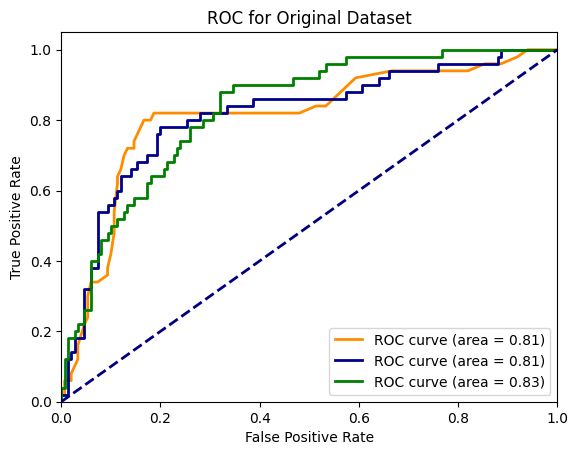

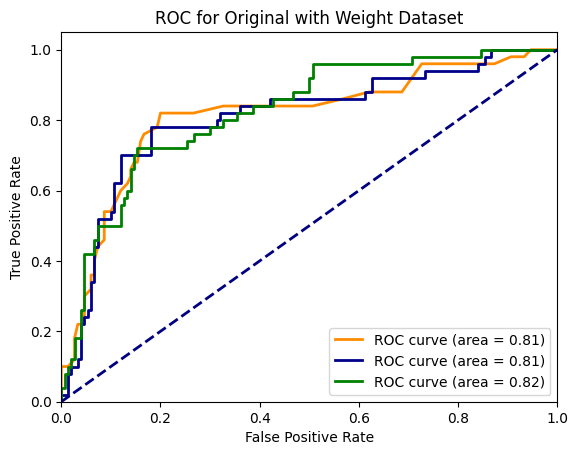

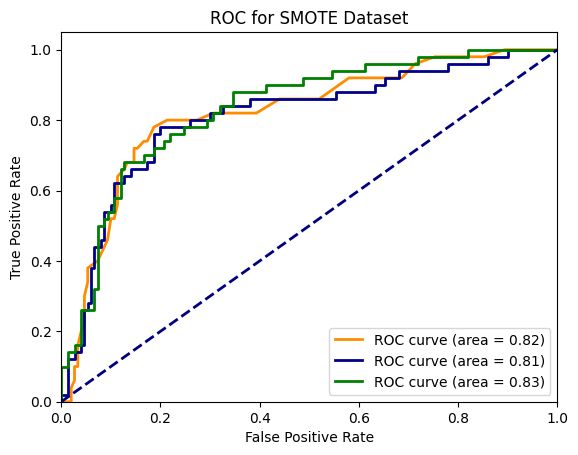

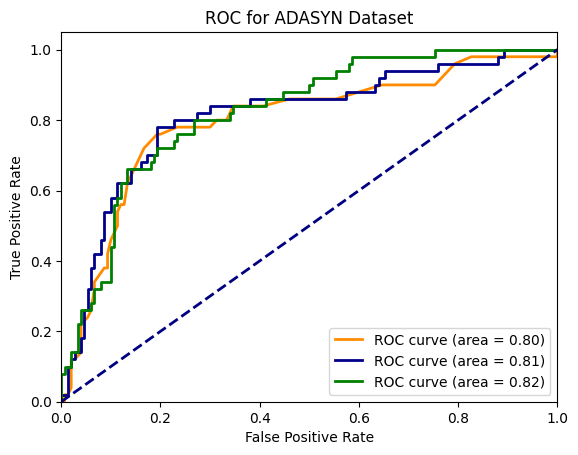

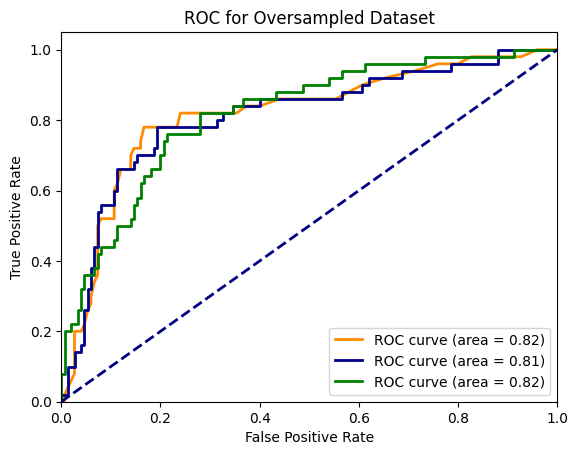

In [11]:
# plot ROC-AUC curve and compare between RF model, LR model and XGB model for each dataset
for i in range(len(rf_models)):
  y_pred_rf = rf_models[i].predict_proba(x_test)[:, 1]
  fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
  roc_auc_rf = auc(fpr_rf, tpr_rf)
  plt.figure()
  plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)

  y_pred_logit = logit_models[i].predict_proba(x_test)[:, 1]
  fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_logit)
  roc_auc_logit = auc(fpr_logit, tpr_logit)
  plt.plot(fpr_logit, tpr_logit, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logit)
  y_pred_xgb = xgb_models[i].predict_proba(x_test)[:, 1]
  fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
  roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
  plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC for {dataset_names[i]} Dataset')
  plt.legend(loc="lower right")
  plt.show()


## Hyperparameter tuning



In [12]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_logit = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

best_rf_models = []
best_logit_models = []
best_xgb_models = []

# Perform GridSearchCV for each model and dataset
for i in range(len(datasets)):
    X_train = datasets[i].drop('fraud_reported', axis=1)
    y_train = datasets[i]['fraud_reported']

    # rf
    print(f"Tuning Random Forest on {dataset_names[i]} dataset...")
    if datasets[i] is df_original_with_weight:
        rf_model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif datasets[i] is df_weighted:
        rf_model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model = RandomForestClassifier(random_state=4263)

    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='f1', cv=5, n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)
    best_rf_models.append(grid_search_rf.best_estimator_)
    print(f"Best parameters for Random Forest on {dataset_names[i]}: {grid_search_rf.best_params_}")

    # lr
    print(f"Tuning Logistic Regression on {dataset_names[i]} dataset...")
    if datasets[i] is df_original_with_weight:
        logit_model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif datasets[i] is df_weighted:
        logit_model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model = LogisticRegression(random_state=4263, max_iter=1000)

    grid_search_logit = GridSearchCV(estimator=logit_model, param_grid=param_grid_logit, scoring='f1', cv=5, n_jobs=-1)
    grid_search_logit.fit(X_train, y_train)
    best_logit_models.append(grid_search_logit.best_estimator_)
    print(f"Best parameters for Logistic Regression on {dataset_names[i]}: {grid_search_logit.best_params_}")

    # XGB
    print(f"Tuning XGBoost on {dataset_names[i]} dataset...")
    if datasets[i] is df_original_with_weight:
        xgb_model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif datasets[i] is df_weighted:
        xgb_model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model = xgb.XGBClassifier(random_state=4263)

    grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='f1', cv=5, n_jobs=-1)
    grid_search_xgb.fit(X_train, y_train)
    best_xgb_models.append(grid_search_xgb.best_estimator_)
    print(f"Best parameters for XGBoost on {dataset_names[i]}: {grid_search_xgb.best_params_}")


Tuning Random Forest on Original dataset...
Best parameters for Random Forest on Original: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Tuning Logistic Regression on Original dataset...
Best parameters for Logistic Regression on Original: {'C': 10, 'solver': 'liblinear'}
Tuning XGBoost on Original dataset...
Best parameters for XGBoost on Original: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Tuning Random Forest on Original with Weight dataset...
Best parameters for Random Forest on Original with Weight: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Tuning Logistic Regression on Original with Weight dataset...
Best parameters for Logistic Regression on Original with Weight: {'C': 0.1, 'solver': 'lbfgs'}
Tuning XGBoost on Original with Weight dataset...
Best parameters for XGBoost on Original with Weight: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Tuning Random Forest on SMOTE dataset...
Best parameters for Random Fo

**Reasoning**:
Evaluate the performance of the models with the best parameters found during hyperparameter tuning.



In [15]:
# calculate the accuracy, precision, recall, f1 score of the best models
best_rf_accuracy = []
best_rf_precision = []
best_rf_recall = []
best_rf_f1 = []

best_logit_accuracy = []
best_logit_precision = []
best_logit_recall = []
best_logit_f1 = []

best_xgb_accuracy = []
best_xgb_precision = []
best_xgb_recall = []
best_xgb_f1 = []

for i in range(len(best_rf_models)):
    y_pred_rf = best_rf_models[i].predict(x_test)
    best_rf_accuracy.append(accuracy_score(y_test, y_pred_rf))
    best_rf_precision.append(precision_score(y_test, y_pred_rf))
    best_rf_recall.append(recall_score(y_test, y_pred_rf))
    best_rf_f1.append(f1_score(y_test, y_pred_rf))

    y_pred_logit = best_logit_models[i].predict(x_test)
    best_logit_accuracy.append(accuracy_score(y_test, y_pred_logit))
    best_logit_precision.append(precision_score(y_test, y_pred_logit))
    best_logit_recall.append(recall_score(y_test, y_pred_logit))
    best_logit_f1.append(f1_score(y_test, y_pred_logit))

    y_pred_xgb = best_xgb_models[i].predict(x_test)
    best_xgb_accuracy.append(accuracy_score(y_test, y_pred_xgb))
    best_xgb_precision.append(precision_score(y_test, y_pred_xgb))
    best_xgb_recall.append(recall_score(y_test, y_pred_xgb))
    best_xgb_f1.append(f1_score(y_test, y_pred_xgb))

# create DataFrames for the metrics
best_rf_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_rf_accuracy,
    'Precision': best_rf_precision,
    'Recall': best_rf_recall,
    'F1 Score': best_rf_f1
})

best_logit_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_logit_accuracy,
    'Precision': best_logit_precision,
    'Recall': best_logit_recall,
    'F1 Score': best_logit_f1
})

best_xgb_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_xgb_accuracy,
    'Precision': best_xgb_precision,
    'Recall': best_xgb_recall,
    'F1 Score': best_xgb_f1
})

print("Random Forest Model Metrics (after tuning):")
display(best_rf_metrics_df)

print("\nLogistic Regression Model Metrics (after tuning):")
display(best_logit_metrics_df)

print("\nXGBoost Model Metrics (after tuning):")
display(best_xgb_metrics_df)

Random Forest Model Metrics (after tuning):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.666667,0.28,0.394366
1,Original with Weight,0.820,0.640000,0.64,0.640000
2,SMOTE,0.790,0.605263,0.46,0.522727
3,ADASYN,0.795,0.621622,0.46,0.528736
4,Oversampled,0.810,0.630435,0.58,0.604167



Logistic Regression Model Metrics (after tuning):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.800,0.619048,0.52,0.565217
1,Original with Weight,0.800,0.571429,0.80,0.666667
2,SMOTE,0.790,0.574074,0.62,0.596154
3,ADASYN,0.785,0.566038,0.60,0.582524
4,Oversampled,0.785,0.557377,0.68,0.612613



XGBoost Model Metrics (after tuning):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.790,0.600000,0.48,0.533333
1,Original with Weight,0.790,0.557143,0.78,0.650000
2,SMOTE,0.815,0.638298,0.60,0.618557
3,ADASYN,0.795,0.609756,0.50,0.549451
4,Oversampled,0.785,0.553846,0.72,0.626087


In [16]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': best_rf_f1,
    'Logistic Regression F1': best_logit_f1,
    'XGBoost F1': best_xgb_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.394366,0.565217,0.533333
1,Original with Weight,0.640000,0.666667,0.650000
2,SMOTE,0.522727,0.596154,0.618557
3,ADASYN,0.528736,0.582524,0.549451
4,Oversampled,0.604167,0.612613,0.626087


# Fine Tuning the different models

## Remove "auto model" columns


In [17]:
# import no auto model and auto make

datasets_no_auto = []
df_no_auto_ori = pd.read_csv(file_path + 'original_cleaned_dataset_edited.csv')
df_no_auto_smote = pd.read_csv(file_path + 'smote_dataset_edited.csv')
df_no_auto_adasyn = pd.read_csv(file_path + 'adasyn_dataset_edited.csv')
df_no_auto_oversampled = pd.read_csv(file_path + 'oversampled_dataset_edited.csv')
df_no_auto_test = pd.read_csv(file_path + 'test_dataset_edited.csv')
df_no_auto_original_with_weight = df_no_auto_ori.copy()
datasets_no_auto = [df_no_auto_ori, df_no_auto_original_with_weight, df_no_auto_smote, df_no_auto_adasyn, df_no_auto_oversampled]

## Retrain models with "no auto" columns


In [18]:
rf_no_auto_models = []
logit_no_auto_models = []
xgb_no_auto_models = []


for i in range(len(datasets_no_auto)):
    print(f"Training models on {dataset_names[i]} dataset (without auto_model columns)...")

    X_train = datasets_no_auto[i].drop('fraud_reported', axis=1)
    y_train = datasets_no_auto[i]['fraud_reported']

    # rf
    print(f"  Training Random Forest on {dataset_names[i]}...")
    if datasets_no_auto[i] is df_no_auto_original_with_weight:
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif datasets_no_auto[i] is df_no_auto_oversampled:
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model_no_auto = RandomForestClassifier(random_state=4263)
    rf_model_no_auto.fit(X_train, y_train)
    rf_no_auto_models.append(rf_model_no_auto)

    # lr
    print(f"  Training Logistic Regression on {dataset_names[i]}...")
    if datasets_no_auto[i] is df_no_auto_original_with_weight:
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif datasets_no_auto[i] is df_no_auto_oversampled:
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model_no_auto = LogisticRegression(random_state=4263, max_iter=1000)
    logit_model_no_auto.fit(X_train, y_train)
    logit_no_auto_models.append(logit_model_no_auto)

    # XGB
    print(f"  Training XGBoost on {dataset_names[i]}...")
    if datasets_no_auto[i] is df_no_auto_original_with_weight:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif datasets_no_auto[i] is df_no_auto_oversampled:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263)
    xgb_model_no_auto.fit(X_train, y_train)
    xgb_no_auto_models.append(xgb_model_no_auto)


Training models on Original dataset (without auto_model columns)...
  Training Random Forest on Original...
  Training Logistic Regression on Original...
  Training XGBoost on Original...
Training models on Original with Weight dataset (without auto_model columns)...
  Training Random Forest on Original with Weight...
  Training Logistic Regression on Original with Weight...
  Training XGBoost on Original with Weight...
Training models on SMOTE dataset (without auto_model columns)...
  Training Random Forest on SMOTE...
  Training Logistic Regression on SMOTE...
  Training XGBoost on SMOTE...
Training models on ADASYN dataset (without auto_model columns)...
  Training Random Forest on ADASYN...
  Training Logistic Regression on ADASYN...
  Training XGBoost on ADASYN...
Training models on Oversampled dataset (without auto_model columns)...
  Training Random Forest on Oversampled...
  Training Logistic Regression on Oversampled...
  Training XGBoost on Oversampled...


In [19]:
# calculate the accuracy, precision, recall, f1 score of the models without 'auto_model' columns
rf_no_auto_accuracy = []
rf_no_auto_precision = []
rf_no_auto_recall = []
rf_no_auto_f1 = []

logit_no_auto_accuracy = []
logit_no_auto_precision = []
logit_no_auto_recall = []
logit_no_auto_f1 = []

xgb_no_auto_accuracy = []
xgb_no_auto_precision = []
xgb_no_auto_recall = []
xgb_no_auto_f1 = []

x_test_no_auto = df_no_auto_test.drop('fraud_reported', axis=1)
y_test_no_auto = df_no_auto_test['fraud_reported']

for i in range(len(rf_no_auto_models)):
  # get the feature names from the fitted model
  rf_features = rf_no_auto_models[i].feature_names_in_
  logit_features = logit_no_auto_models[i].feature_names_in_
  xgb_features = xgb_no_auto_models[i].get_booster().feature_names

  # reindex the test dataframe to match the training feature order
  x_test_rf = x_test_no_auto.reindex(columns=rf_features, fill_value=0)
  x_test_logit = x_test_no_auto.reindex(columns=logit_features, fill_value=0)
  x_test_xgb = x_test_no_auto.reindex(columns=xgb_features, fill_value=0)


  y_pred_rf_no_auto = rf_no_auto_models[i].predict(x_test_rf)
  rf_no_auto_accuracy.append(accuracy_score(y_test_no_auto, y_pred_rf_no_auto))
  rf_no_auto_precision.append(precision_score(y_test_no_auto, y_pred_rf_no_auto))
  rf_no_auto_recall.append(recall_score(y_test_no_auto, y_pred_rf_no_auto))
  rf_no_auto_f1.append(f1_score(y_test_no_auto, y_pred_rf_no_auto))

  y_pred_logit_no_auto = logit_no_auto_models[i].predict(x_test_logit)
  logit_no_auto_accuracy.append(accuracy_score(y_test_no_auto, y_pred_logit_no_auto))
  logit_no_auto_precision.append(precision_score(y_test_no_auto, y_pred_logit_no_auto))
  logit_no_auto_recall.append(recall_score(y_test_no_auto, y_pred_logit_no_auto))
  logit_no_auto_f1.append(f1_score(y_test_no_auto, y_pred_logit_no_auto))

  y_pred_xgb_no_auto = xgb_no_auto_models[i].predict(x_test_xgb)
  xgb_no_auto_accuracy.append(accuracy_score(y_test_no_auto, y_pred_xgb_no_auto))
  xgb_no_auto_precision.append(precision_score(y_test_no_auto, y_pred_xgb_no_auto))
  xgb_no_auto_recall.append(recall_score(y_test_no_auto, y_pred_xgb_no_auto))
  xgb_no_auto_f1.append(f1_score(y_test_no_auto, y_pred_xgb_no_auto))

# create DataFrames for the metrics
rf_no_auto_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_no_auto_accuracy,
    'Precision': rf_no_auto_precision,
    'Recall': rf_no_auto_recall,
    'F1 Score': rf_no_auto_f1
})

logit_no_auto_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_no_auto_accuracy,
    'Precision': logit_no_auto_precision,
    'Recall': logit_no_auto_recall,
    'F1 Score': logit_no_auto_f1
})

xgb_no_auto_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_no_auto_accuracy,
    'Precision': xgb_no_auto_precision,
    'Recall': xgb_no_auto_recall,
    'F1 Score': xgb_no_auto_f1
})

print("Random Forest Model Metrics (without auto_model columns):")
display(rf_no_auto_metrics_df)

print("\nLogistic Regression Model Metrics (without auto_model columns):")
display(logit_no_auto_metrics_df)

print("\nXGBoost Model Metrics (without auto_model columns):")
display(xgb_no_auto_metrics_df)

print("\nRandom Forest Model Metrics (Original Data):")
display(rf_metrics_df)

print("\nLogistic Regression Model Metrics (Original Data):")
display(logit_metrics_df)

print("\nXGBoost Model Metrics (Original Data):")
display(xgb_metrics_df)

Random Forest Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.620690,0.36,0.455696
1,Original with Weight,0.785,0.684211,0.26,0.376812
2,SMOTE,0.800,0.638889,0.46,0.534884
3,ADASYN,0.815,0.675676,0.50,0.574713
4,Oversampled,0.790,0.617647,0.42,0.500000



Logistic Regression Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.835,0.729730,0.54,0.620690
1,Original with Weight,0.815,0.591549,0.84,0.694215
2,SMOTE,0.835,0.717949,0.56,0.629213
3,ADASYN,0.830,0.710526,0.54,0.613636
4,Oversampled,0.825,0.647059,0.66,0.653465



XGBoost Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.790,0.633333,0.38,0.475000
1,Original with Weight,0.775,0.564103,0.44,0.494382
2,SMOTE,0.800,0.619048,0.52,0.565217
3,ADASYN,0.780,0.571429,0.48,0.521739
4,Oversampled,0.800,0.638889,0.46,0.534884



Random Forest Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.770,0.611111,0.22,0.323529
1,Original with Weight,0.775,0.647059,0.22,0.328358
2,SMOTE,0.795,0.621622,0.46,0.528736
3,ADASYN,0.780,0.593750,0.38,0.463415
4,Oversampled,0.785,0.620690,0.36,0.455696



Logistic Regression Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.675000,0.54,0.600000
1,Original with Weight,0.785,0.549296,0.78,0.644628
2,SMOTE,0.815,0.651163,0.56,0.602151
3,ADASYN,0.810,0.642857,0.54,0.586957
4,Oversampled,0.815,0.622642,0.66,0.640777



XGBoost Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.800,0.631579,0.48,0.545455
1,Original with Weight,0.795,0.609756,0.50,0.549451
2,SMOTE,0.815,0.675676,0.50,0.574713
3,ADASYN,0.805,0.627907,0.54,0.580645
4,Oversampled,0.785,0.594595,0.44,0.505747



Hyperparameter tune the Random Forest, Logistic Regression, and XGBoost models on the "no_auto" datasets using GridSearchCV with cross-validation, evaluate their performance, and compare their F1 scores to the models trained on the original data and data with selected features.

In [20]:
param_grid_rf_tuned = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10, 20]
}

param_grid_logit_tuned = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_xgb_tuned = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

## Perform gridsearchcv on no auto datasets



In [21]:
best_rf_no_auto_models = []
best_logit_no_auto_models = []
best_xgb_no_auto_models = []

# perform GridSearchCV for each model and no_auto dataset
for i in range(len(datasets_no_auto)):
    print(f"Tuning models on {dataset_names[i]} dataset (without auto_model columns)...")

    X_train = datasets_no_auto[i].drop('fraud_reported', axis=1)
    y_train = datasets_no_auto[i]['fraud_reported']

    # rf
    print(f"  Tuning Random Forest on {dataset_names[i]}...")
    if dataset_names[i] == 'Original with Weight':
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif dataset_names[i] == 'Oversampled':
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model_no_auto = RandomForestClassifier(random_state=4263)

    grid_search_rf_no_auto = GridSearchCV(estimator=rf_model_no_auto, param_grid=param_grid_rf_tuned, scoring='f1', cv=5, n_jobs=-1)
    grid_search_rf_no_auto.fit(X_train, y_train)
    best_rf_no_auto_models.append(grid_search_rf_no_auto.best_estimator_)
    print(f"  Best parameters for Random Forest on {dataset_names[i]}: {grid_search_rf_no_auto.best_params_}")

    # lr
    print(f"  Tuning Logistic Regression on {dataset_names[i]}...")
    if dataset_names[i] == 'Original with Weight':
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif dataset_names[i] == 'Oversampled':
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model_no_auto = LogisticRegression(random_state=4263, max_iter=1000)

    grid_search_logit_no_auto = GridSearchCV(estimator=logit_model_no_auto, param_grid=param_grid_logit_tuned, scoring='f1', cv=5, n_jobs=-1)
    grid_search_logit_no_auto.fit(X_train, y_train)
    best_logit_no_auto_models.append(grid_search_logit_no_auto.best_estimator_)
    print(f"  Best parameters for Logistic Regression on {dataset_names[i]}: {grid_search_logit_no_auto.best_params_}")

    # XGB
    print(f"  Tuning XGBoost on {dataset_names[i]}...")
    if dataset_names[i] == 'Original with Weight':
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif dataset_names[i] == 'Oversampled':
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263)

    grid_search_xgb_no_auto = GridSearchCV(estimator=xgb_model_no_auto, param_grid=param_grid_xgb_tuned, scoring='f1', cv=5, n_jobs=-1)
    grid_search_xgb_no_auto.fit(X_train, y_train)
    best_xgb_no_auto_models.append(grid_search_xgb_no_auto.best_estimator_)
    print(f"  Best parameters for XGBoost on {dataset_names[i]}: {grid_search_xgb_no_auto.best_params_}")


Tuning models on Original dataset (without auto_model columns)...
  Tuning Random Forest on Original...
  Best parameters for Random Forest on Original: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
  Tuning Logistic Regression on Original...
  Best parameters for Logistic Regression on Original: {'C': 1, 'solver': 'lbfgs'}
  Tuning XGBoost on Original...
  Best parameters for XGBoost on Original: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Tuning models on Original with Weight dataset (without auto_model columns)...
  Tuning Random Forest on Original with Weight...
  Best parameters for Random Forest on Original with Weight: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 300}
  Tuning Logistic Regression on Original with Weight...
  Best parameters for Logistic Regression on Original with Weight: {'C': 0.1, 'solver': 'liblinear'}
  Tuning XGBoost on Original with Weight...
  Best parameters for XGBoost on Original with Weight: {'learning_

In [22]:
# test the best hyperparamters models on the non-auto datasets
rf_no_auto_tuned_accuracy = []
rf_no_auto_tuned_precision = []
rf_no_auto_tuned_recall = []
rf_no_auto_tuned_f1 = []

logit_no_auto_tuned_accuracy = []
logit_no_auto_tuned_precision = []
logit_no_auto_tuned_recall = []
logit_no_auto_tuned_f1 = []

xgb_no_auto_tuned_accuracy = []
xgb_no_auto_tuned_precision = []
xgb_no_auto_tuned_recall = []
xgb_no_auto_tuned_f1 = []

y_test_no_auto = df_no_auto_test['fraud_reported']
x_test_no_auto = df_no_auto_test.drop('fraud_reported', axis=1)

for i in range(len(best_rf_no_auto_models)):
  y_pred_rf_no_auto_tuned = best_rf_no_auto_models[i].predict(x_test_no_auto)
  rf_no_auto_tuned_accuracy.append(accuracy_score(y_test_no_auto, y_pred_rf_no_auto_tuned))
  rf_no_auto_tuned_precision.append(precision_score(y_test_no_auto, y_pred_rf_no_auto_tuned))
  rf_no_auto_tuned_recall.append(recall_score(y_test_no_auto, y_pred_rf_no_auto_tuned))
  rf_no_auto_tuned_f1.append(f1_score(y_test_no_auto, y_pred_rf_no_auto_tuned))

  y_pred_logit_no_auto_tuned = best_logit_no_auto_models[i].predict(x_test_no_auto)
  logit_no_auto_tuned_accuracy.append(accuracy_score(y_test_no_auto, y_pred_logit_no_auto_tuned))
  logit_no_auto_tuned_precision.append(precision_score(y_test_no_auto, y_pred_logit_no_auto_tuned))
  logit_no_auto_tuned_recall.append(recall_score(y_test_no_auto, y_pred_logit_no_auto_tuned))
  logit_no_auto_tuned_f1.append(f1_score(y_test_no_auto, y_pred_logit_no_auto_tuned))

  y_pred_xgb_no_auto_tuned = best_xgb_no_auto_models[i].predict(x_test_no_auto)
  xgb_no_auto_tuned_accuracy.append(accuracy_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))
  xgb_no_auto_tuned_precision.append(precision_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))
  xgb_no_auto_tuned_recall.append(recall_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))
  xgb_no_auto_tuned_f1.append(f1_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))

rf_no_auto_tuned_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_no_auto_tuned_accuracy,
    'Precision': rf_no_auto_tuned_precision,
    'Recall': rf_no_auto_tuned_recall,
    'F1 Score': rf_no_auto_tuned_f1
})

logit_no_auto_tuned_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_no_auto_tuned_accuracy,
    'Precision': logit_no_auto_tuned_precision,
    'Recall': logit_no_auto_tuned_recall,
    'F1 Score': logit_no_auto_tuned_f1
})

xgb_no_auto_tuned_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_no_auto_tuned_accuracy,
    'Precision': xgb_no_auto_tuned_precision,
    'Recall': xgb_no_auto_tuned_recall,
    'F1 Score': xgb_no_auto_tuned_f1
})

print("Random Forest Model Metrics (without auto_model columns):")
display(rf_no_auto_tuned_metrics_df)

print("\nLogistic Regression Model Metrics (without auto_model columns):")
display(logit_no_auto_tuned_metrics_df)

print("\nXGBoost Model Metrics (without auto_model columns):")
display(xgb_no_auto_tuned_metrics_df)

Random Forest Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.800,0.678571,0.38,0.487179
1,Original with Weight,0.825,0.636364,0.70,0.666667
2,SMOTE,0.810,0.636364,0.56,0.595745
3,ADASYN,0.800,0.613636,0.54,0.574468
4,Oversampled,0.820,0.629630,0.68,0.653846



Logistic Regression Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.835,0.729730,0.54,0.620690
1,Original with Weight,0.815,0.594203,0.82,0.689076
2,SMOTE,0.810,0.607143,0.68,0.641509
3,ADASYN,0.805,0.596491,0.68,0.635514
4,Oversampled,0.810,0.600000,0.72,0.654545



XGBoost Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.589744,0.46,0.516854
1,Original with Weight,0.790,0.557143,0.78,0.650000
2,SMOTE,0.800,0.608696,0.56,0.583333
3,ADASYN,0.795,0.609756,0.50,0.549451
4,Oversampled,0.765,0.525424,0.62,0.568807


In [23]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': rf_no_auto_tuned_f1,
    'Logistic Regression F1': logit_no_auto_tuned_f1,
    'XGBoost F1': xgb_no_auto_tuned_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.487179,0.620690,0.516854
1,Original with Weight,0.666667,0.689076,0.650000
2,SMOTE,0.595745,0.641509,0.583333
3,ADASYN,0.574468,0.635514,0.549451
4,Oversampled,0.653846,0.654545,0.568807


## Review feature selection attempts



In [25]:
print("Comparison of F1 Scores (Original vs. without auto_model columns):")

print("\nRandom Forest F1 Scores:")
comparison_rf_f1 = pd.DataFrame({
    'Dataset': rf_metrics_df['Dataset'],
    'Original F1': rf_metrics_df['F1 Score'],
    'No Auto_Model F1': rf_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': rf_no_auto_tuned_metrics_df['F1 Score']

})
display(comparison_rf_f1)

print("\nLogistic Regression F1 Scores:")
comparison_logit_f1 = pd.DataFrame({
    'Dataset': logit_metrics_df['Dataset'],
    'Original F1': logit_metrics_df['F1 Score'],
    'No Auto_Model F1': logit_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': logit_no_auto_tuned_metrics_df['F1 Score']
})
display(comparison_logit_f1)

print("\nXGBoost F1 Scores:")
comparison_xgb_f1 = pd.DataFrame({
    'Dataset': xgb_metrics_df['Dataset'],
    'Original F1': xgb_metrics_df['F1 Score'],
    'No Auto_Model F1': xgb_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': xgb_no_auto_tuned_metrics_df['F1 Score']
})
display(comparison_xgb_f1)

Comparison of F1 Scores (Original vs. without auto_model columns):

Random Forest F1 Scores:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1
0,Original,0.323529,0.455696,0.487179
1,Original with Weight,0.328358,0.376812,0.666667
2,SMOTE,0.528736,0.534884,0.595745
3,ADASYN,0.463415,0.574713,0.574468
4,Oversampled,0.455696,0.500000,0.653846



Logistic Regression F1 Scores:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1
0,Original,0.600000,0.620690,0.620690
1,Original with Weight,0.644628,0.694215,0.689076
2,SMOTE,0.602151,0.629213,0.641509
3,ADASYN,0.586957,0.613636,0.635514
4,Oversampled,0.640777,0.653465,0.654545



XGBoost F1 Scores:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1
0,Original,0.545455,0.475000,0.516854
1,Original with Weight,0.549451,0.494382,0.650000
2,SMOTE,0.574713,0.565217,0.583333
3,ADASYN,0.580645,0.521739,0.549451
4,Oversampled,0.505747,0.534884,0.568807


## Final F1 Score comparsion

In [27]:
print("\nComparison of F1 Scores for Random Forest Model (Original, No Auto_Model, Selected Features - Tuned):")
comparison_rf_f1_tuned = pd.DataFrame({
    'Dataset': rf_metrics_df['Dataset'],
    'Original F1': rf_metrics_df['F1 Score'],
    'Original (Tuned) F1': best_rf_metrics_df['F1 Score'],
    'No Auto_Model F1': rf_no_auto_metrics_df['F1 Score'],
})
display(comparison_rf_f1_tuned)

print("\nComparison of F1 Scores for Logistic Regression Model (Original, No Auto_Model, Selected Features - Tuned):")
comparison_logit_f1_tuned = pd.DataFrame({
    'Dataset': logit_metrics_df['Dataset'],
    'Original F1': logit_metrics_df['F1 Score'],
    'Original (Tuned) F1': best_logit_metrics_df['F1 Score'],
    'No Auto_Model F1': logit_no_auto_metrics_df['F1 Score'],
})
display(comparison_logit_f1_tuned)

print("\nComparison of F1 Scores for XGBoost Model (Original, No Auto_Model, Selected Features - Tuned):")
comparison_xgb_f1_tuned = pd.DataFrame({
    'Dataset': xgb_metrics_df['Dataset'],
    'Original F1': xgb_metrics_df['F1 Score'],
    'Original (Tuned) F1': best_xgb_metrics_df['F1 Score'],
    'No Auto_Model F1': xgb_no_auto_metrics_df['F1 Score'],
})
display(comparison_xgb_f1_tuned)


Comparison of F1 Scores for Random Forest Model (Original, No Auto_Model, Selected Features - Tuned):


,Dataset,Original F1,Original (Tuned) F1,No Auto_Model F1
0,Original,0.323529,0.394366,0.455696
1,Original with Weight,0.328358,0.640000,0.376812
2,SMOTE,0.528736,0.522727,0.534884
3,ADASYN,0.463415,0.528736,0.574713
4,Oversampled,0.455696,0.604167,0.500000



Comparison of F1 Scores for Logistic Regression Model (Original, No Auto_Model, Selected Features - Tuned):


,Dataset,Original F1,Original (Tuned) F1,No Auto_Model F1
0,Original,0.600000,0.565217,0.620690
1,Original with Weight,0.644628,0.666667,0.694215
2,SMOTE,0.602151,0.596154,0.629213
3,ADASYN,0.586957,0.582524,0.613636
4,Oversampled,0.640777,0.612613,0.653465



Comparison of F1 Scores for XGBoost Model (Original, No Auto_Model, Selected Features - Tuned):


,Dataset,Original F1,Original (Tuned) F1,No Auto_Model F1
0,Original,0.545455,0.533333,0.475000
1,Original with Weight,0.549451,0.650000,0.494382
2,SMOTE,0.574713,0.618557,0.565217
3,ADASYN,0.580645,0.549451,0.521739
4,Oversampled,0.505747,0.626087,0.534884


## Best Model Analysis

In [37]:
# create a confusion matrix for the best model 
original_with_weight_index = dataset_names.index('Original with Weight')
selected_logit_model = logit_no_auto_models[original_with_weight_index]

y_pred_selected = selected_logit_model.predict(x_test_no_auto)
cm = confusion_matrix(y_test_no_auto, y_pred_selected)
print("\nConfusion Matrix:")
print(pd.DataFrame(
        cm,
        index=['Actual Non-Fraud (0)', 'Actual Fraud (1)'],
        columns=['Predicted Non-Fraud (0)', 'Predicted Fraud (1)']
    ))

print("\nClassification Report:")
print(classification_report(y_test_no_auto, selected_logit_model.predict(x_test_no_auto), digits=4))


Confusion Matrix:
                      Predicted Non-Fraud (0)  Predicted Fraud (1)
Actual Non-Fraud (0)                      121                   29
Actual Fraud (1)                            8                   42

Classification Report:
              precision    recall  f1-score   support

           0     0.9380    0.8067    0.8674       150
           1     0.5915    0.8400    0.6942        50

    accuracy                         0.8150       200
   macro avg     0.7648    0.8233    0.7808       200
weighted avg     0.8514    0.8150    0.8241       200



## Explanability of selected model (No_Auto tuned logistics regression model trained using original dataset with weight)

In [ ]:
original_with_weight_index = dataset_names.index('Original with Weight')
selected_logit_model = logit_no_auto_models[original_with_weight_index]

print(f"Selected Model: {selected_logit_model}")

Selected Model: LogisticRegression(C=0.1,
                   class_weight={np.int64(0): np.float64(0.6633499170812603),
                                 np.int64(1): np.float64(2.030456852791878)},
                   max_iter=1000, random_state=4263, solver='liblinear')


In [ ]:
# get the coefficients from the selected Logistic Regression model
coefficients = selected_logit_model.coef_[0]

# get the feature names from the training data used for this model
original_with_weight_no_auto_index = dataset_names.index('Original with Weight')
X_train_selected_model = datasets_no_auto[original_with_weight_no_auto_index].drop('fraud_reported', axis=1)
feature_names_selected_model = X_train_selected_model.columns

coefficients_df = pd.DataFrame({'Feature': feature_names_selected_model, 'Coefficient': coefficients})

# sort coefficients by their absolute magnitude to see the most influential features
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

print("Model Coefficients:")
display(coefficients_df)

Model Coefficients:


,Feature,Coefficient
43,incident_severity_Major Damage,1.530746
26,insured_hobbies_Games,0.930203
44,incident_severity_Minor Damage,-0.544976
45,incident_severity_Total Loss,-0.539423
46,incident_severity_Trivial Damage,-0.493408
...,...,...
8,insured_education_level,0.010883
57,incident_state_VA,0.002905
52,incident_state_NC,0.001846
10,capital-loss,0.001441


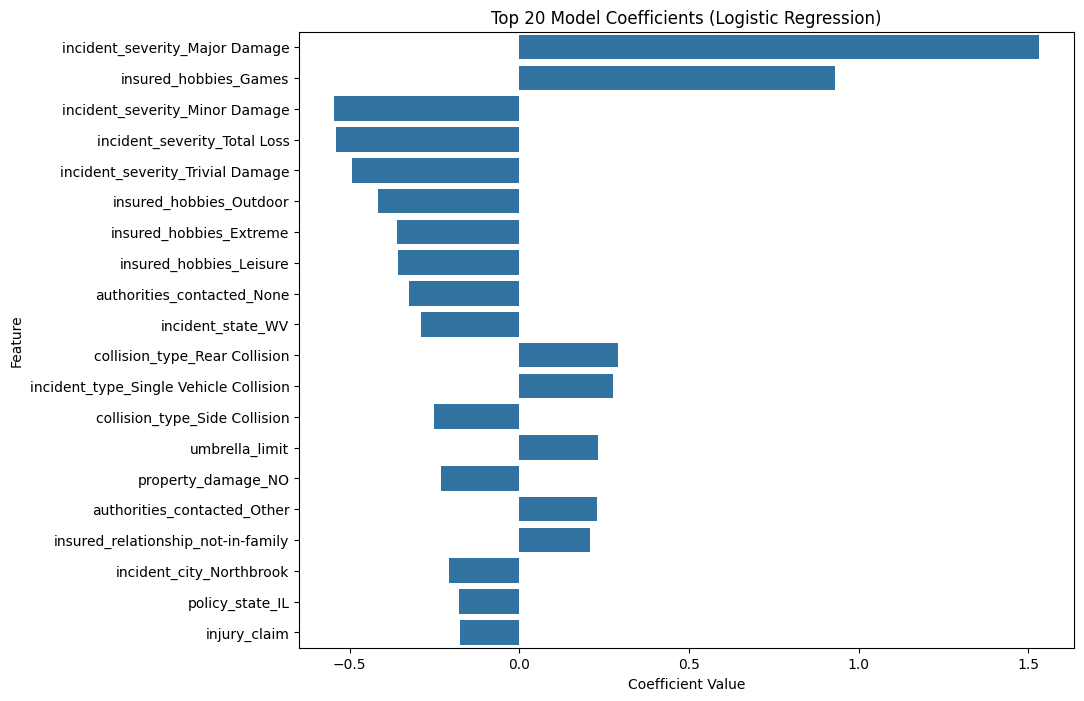

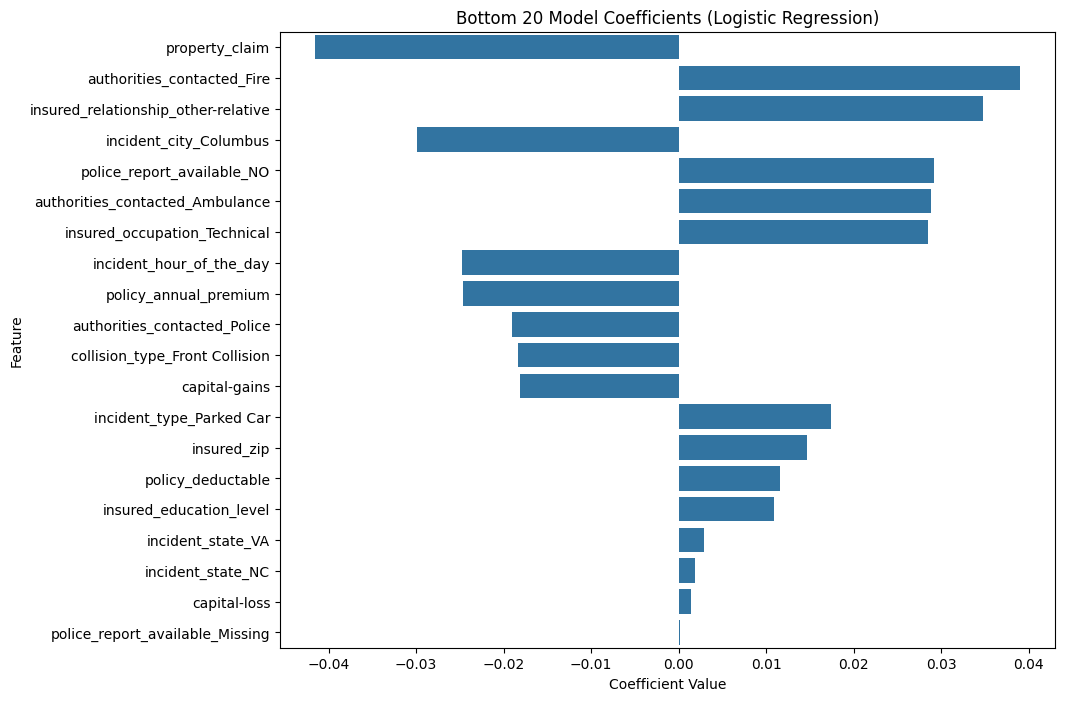

In [ ]:
# visualise the top N coefficients
n_top_coefficients = 20

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df.head(n_top_coefficients))
plt.title(f'Top {n_top_coefficients} Model Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# visualise the bottom N coefficients (most negative)
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df.tail(n_top_coefficients))
plt.title(f'Bottom {n_top_coefficients} Model Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

Impact of Coefficient Magnitude: The absolute magnitude of the coefficients directly reflects the strength of a feature's influence. Features with larger absolute values (both positive and negative) are considered more important by the model in determining the probability of fraud.

Most Influential Positive Predictors of Fraud: Features with large positive coefficients are the strongest indicators that the model predicts a higher probability of fraud. The analysis showed that incident severity, specifically 'Major Damage', and certain insured hobbies ('Games') have the most significant positive impact on the likelihood of a claim being fraudulent. This suggests that claims involving major damage and policyholders who engage in 'Games' as a hobby are strongly associated with an increased probability of fraud according to this model.

Most Influential Negative Predictors of Fraud: Features with large negative coefficients are the strongest indicators that the model predicts a lower probability of fraud. The analysis highlighted that incident severity levels lower than 'Major Damage', such as 'Minor Damage', 'Total Loss', and 'Trivial Damage', have a notable negative impact on the likelihood of fraud. This aligns with the expectation that less severe incidents are less likely to be fraudulent.



In [ ]:
# download the best model as a pickle file
import pickle
best_model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, C = 0.1, solver = 'liblinear', max_iter=1000)
# best model is no_auto logistic regression on original data with class weights

#with open('best_logistic_regression_model_no_auto_original_with_weight.pkl', 'wb') as f:
#    pickle.dump(best_model, f)

best_model.fit(X_train_model, y_train['Original with Weight'])


NameError: name 'X_train_selected_model' is not defined